# Import

In [1]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
  
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables) 

{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'ID': 249, 'type': 'NATIVE', 'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'venue': '8th Intl Workshop on Expert Systems and their Applications, 

# Visualization of Distribution per Class across the Features

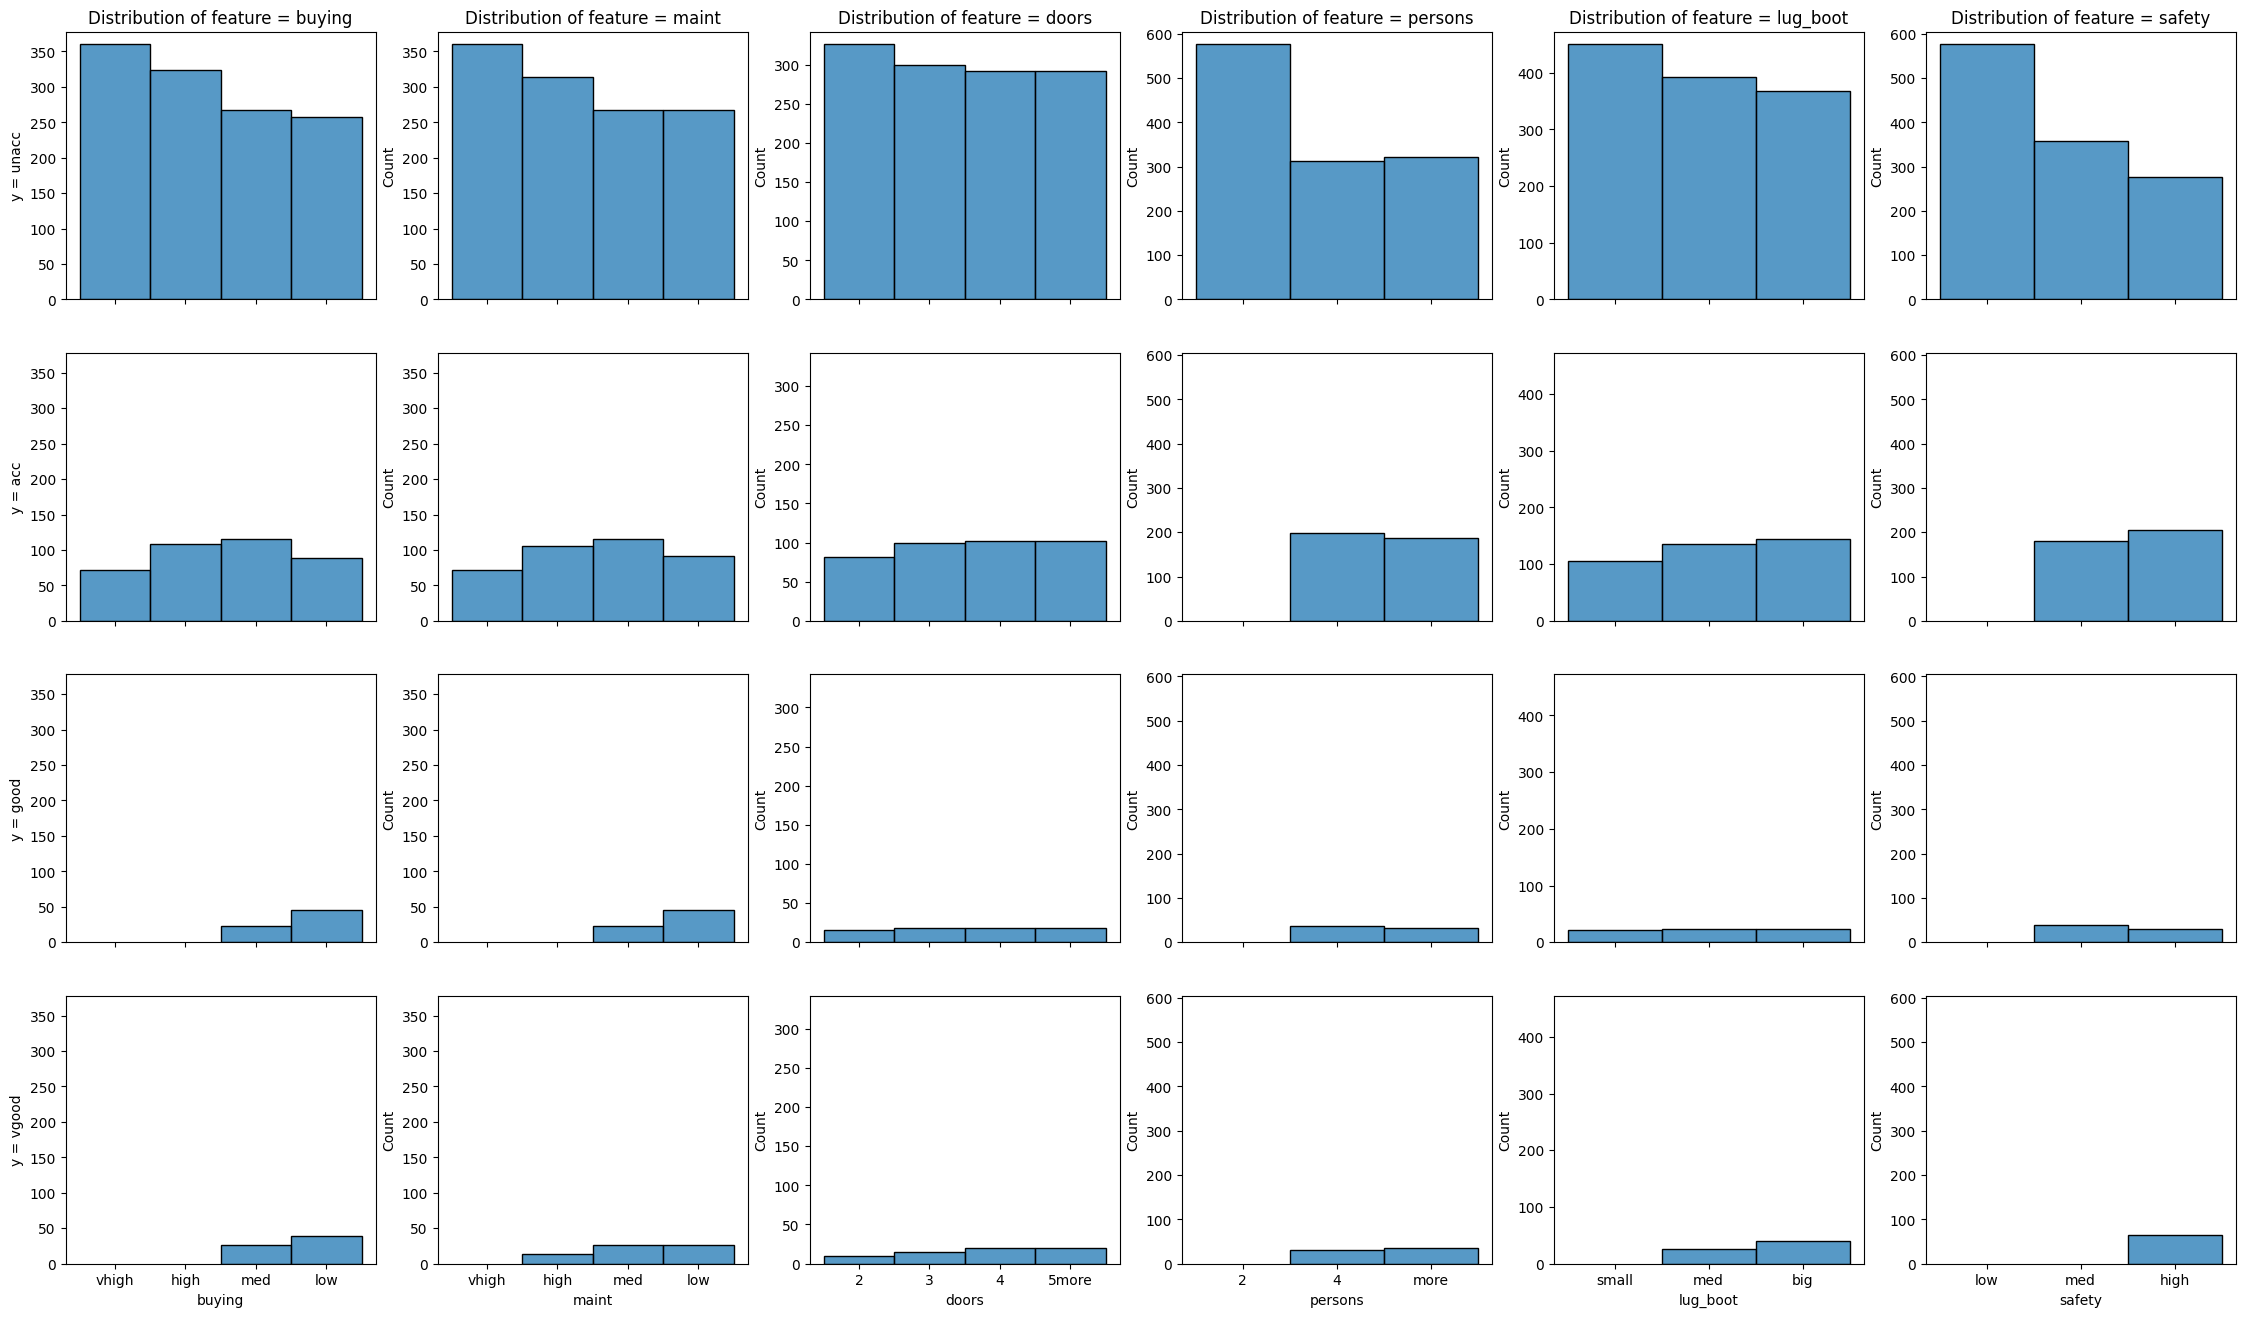

In [3]:
y_custom_order = ['unacc', 'acc', 'good', 'vgood']

fig, axes = plt.subplots(
    nrows=np.unique(y_custom_order).shape[0], 
    ncols=len(X.columns), 
    figsize=(28, 16),
    sharex='col',
    sharey='col'
)

for row_idx, y_value in enumerate(y_custom_order):
    for col_idx, feature in enumerate(X.columns):
        ax = axes[row_idx, col_idx]
        subset = X.loc[y.values==y_value, feature]
        sns.histplot(subset, ax=ax)

        if row_idx == 0:
            ax.set_title(f'Distribution of feature = {feature}')
        if col_idx == 0:
            ax.set_ylabel(f'y = {y_value}')


# No KFold Validation (Regular Holdout validation)

Score: 0.9884


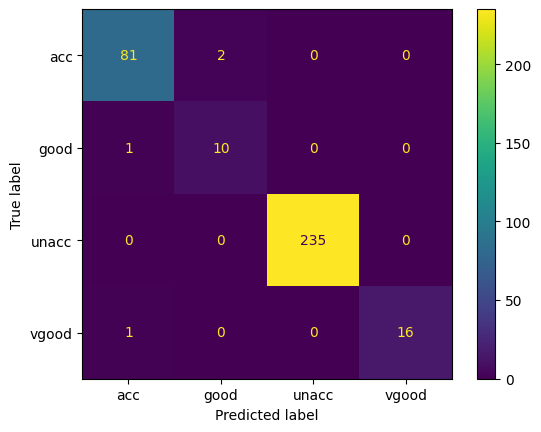

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.2,
    random_state=42
)

pl = Pipeline([
    ('ohe', OneHotEncoder()),
    ('svc', SVC(kernel='rbf', C=1e2)),
])

pl.fit(X_train, y_train.values.ravel())

score = pl.score(X_test, y_test.values.ravel())

print(f'Score: {score:.4f}')

ConfusionMatrixDisplay.from_estimator(pl, X_test, y_test.values.ravel());

With just using a simple split (no cross-validation), we trained the model using the shuffled 80% of the data and tested on the remaining 20%, the model gives a score of 98.84% accuracy. But could the randomization of the training and testing data affected the results?

# Define Function for using Kfold Cross-Validation

In [5]:
def fold_score(X, y, fold, name):
    scores = {'linear': [], 'rbf': [], 'poly': []}

    y = y.values.ravel()
    for i, (train_index, test_index) in enumerate(fold.split(X, y)):
        for kernel in scores.keys():

            pl = Pipeline([
                ('ohe', OneHotEncoder()),
                ('svc', SVC(kernel=kernel, C=1e2)),
            ])
            
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            pl.fit(X_train_fold, y_train_fold)
            pl_score = pl.score(X_test_fold, y_test_fold)
            print(f'For fold {i+1} at kernel = {kernel:<10}: {pl_score:>10.4f}')
            scores[kernel].append(pl_score)

    scores_df = pd.DataFrame(scores)
    scores_df = scores_df.mean().to_frame().T
    scores_df['label'] = name
    scores_df = scores_df[['label', 'linear', 'rbf', 'poly']]
    return scores_df

This function takes our X and y data and a cross-validator object. It returns a 1x3 data that shows the average scores of the splits according to the kernel used. The model here uses an SVC algorithm.

# Stratified K-Fold Cross-Validation

### Random

In [6]:
stratified_kfold_score_random = fold_score(X, y, StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 'stratified_kfold_score_random')
stratified_kfold_score_random

For fold 1 at kernel = linear    :     0.9364
For fold 1 at kernel = rbf       :     1.0000
For fold 1 at kernel = poly      :     1.0000
For fold 2 at kernel = linear    :     0.9509
For fold 2 at kernel = rbf       :     0.9971
For fold 2 at kernel = poly      :     0.9971
For fold 3 at kernel = linear    :     0.9277
For fold 3 at kernel = rbf       :     1.0000
For fold 3 at kernel = poly      :     1.0000
For fold 4 at kernel = linear    :     0.9449
For fold 4 at kernel = rbf       :     1.0000
For fold 4 at kernel = poly      :     1.0000
For fold 5 at kernel = linear    :     0.9391
For fold 5 at kernel = rbf       :     1.0000
For fold 5 at kernel = poly      :     1.0000


,label,linear,rbf,poly
0,stratified_kfold_score_random,0.939817,0.999422,0.999422


### Non-Random

In [7]:
stratified_kfold_score_nonrandom = fold_score(X, y, StratifiedKFold(n_splits=5), 'stratified_kfold_score_nonrandom')
stratified_kfold_score_nonrandom

For fold 1 at kernel = linear    :     0.7457
For fold 1 at kernel = rbf       :     0.8150
For fold 1 at kernel = poly      :     0.8179
For fold 2 at kernel = linear    :     0.7977
For fold 2 at kernel = rbf       :     0.8902
For fold 2 at kernel = poly      :     0.8815
For fold 3 at kernel = linear    :     0.7717
For fold 3 at kernel = rbf       :     0.9075
For fold 3 at kernel = poly      :     0.9393
For fold 4 at kernel = linear    :     0.8580
For fold 4 at kernel = rbf       :     0.9217
For fold 4 at kernel = poly      :     0.9420
For fold 5 at kernel = linear    :     0.9159
For fold 5 at kernel = rbf       :     0.9420
For fold 5 at kernel = poly      :     0.9449


,label,linear,rbf,poly
0,stratified_kfold_score_nonrandom,0.817788,0.895297,0.905137


For three different kernels, poly kernel (with a default degree of 3) returned the highest average score.

# Regular K-Fold Cross Validation

### Random

In [8]:
regular_kfold_score_random = fold_score(X, y, KFold(n_splits=5, shuffle=True, random_state=42), 'regular_kfold_score_random')
regular_kfold_score_random

For fold 1 at kernel = linear    :     0.9393
For fold 1 at kernel = rbf       :     0.9884
For fold 1 at kernel = poly      :     0.9942
For fold 2 at kernel = linear    :     0.9306
For fold 2 at kernel = rbf       :     1.0000
For fold 2 at kernel = poly      :     1.0000
For fold 3 at kernel = linear    :     0.9422
For fold 3 at kernel = rbf       :     1.0000
For fold 3 at kernel = poly      :     1.0000
For fold 4 at kernel = linear    :     0.9420
For fold 4 at kernel = rbf       :     1.0000
For fold 4 at kernel = poly      :     1.0000
For fold 5 at kernel = linear    :     0.9217
For fold 5 at kernel = rbf       :     0.9942
For fold 5 at kernel = poly      :     1.0000


,label,linear,rbf,poly
0,regular_kfold_score_random,0.935181,0.996528,0.998844


### Non-Random

In [9]:
regular_kfold_score_nonrandom = fold_score(X, y, KFold(n_splits=5), 'regular_kfold_score_nonrandom')
regular_kfold_score_nonrandom

For fold 1 at kernel = linear    :     0.8497
For fold 1 at kernel = rbf       :     0.8179
For fold 1 at kernel = poly      :     0.8179
For fold 2 at kernel = linear    :     0.8873
For fold 2 at kernel = rbf       :     0.9220
For fold 2 at kernel = poly      :     0.9191
For fold 3 at kernel = linear    :     0.8699
For fold 3 at kernel = rbf       :     0.9884
For fold 3 at kernel = poly      :     0.9913
For fold 4 at kernel = linear    :     0.8261
For fold 4 at kernel = rbf       :     0.8058
For fold 4 at kernel = poly      :     0.7971
For fold 5 at kernel = linear    :     0.7478
For fold 5 at kernel = rbf       :     0.7246
For fold 5 at kernel = poly      :     0.7072


,label,linear,rbf,poly
0,regular_kfold_score_nonrandom,0.83617,0.851752,0.846534


For the three different kernels, rbf kernel returned the highest average score.

# Summary

In [10]:
print(f'Simple train_test_split score = {score}')

Simple train_test_split score = 0.9884393063583815


In [11]:
summary = pd.concat([
    stratified_kfold_score_random,
    stratified_kfold_score_nonrandom,
    regular_kfold_score_random,
    regular_kfold_score_nonrandom
],).reset_index(drop=True)
summary

,label,linear,rbf,poly
0,stratified_kfold_score_random,0.939817,0.999422,0.999422
1,stratified_kfold_score_nonrandom,0.817788,0.895297,0.905137
2,regular_kfold_score_random,0.935181,0.996528,0.998844
3,regular_kfold_score_nonrandom,0.836170,0.851752,0.846534


When using the simple train_test_split or hold-out validation, it reported a high score of 98.84%. Using cross-validation (either stratified or regular), the best scores are 99.99% and 99.88% respectively, which shows that for this dataset, randomizing the train data and test data results in a good model.

For the non-random case (where test and train data are selected on how they are ordered via their original index), resulted in a relatively worse model. The reason for this could be due to the low count of other classes ('vgood' and 'good') hence if data was not shuffled, very little for those could have been selected during training hence resulting in poor test results.